# Wrangle TRI Data

Toxic Release Inventory data is available for download in .csv format for individual years. I downloaded each [TRI basic data file](https://www.epa.gov/toxics-release-inventory-tri-program/tri-basic-data-files-calendar-years-1987-2018) for the US for all years available, 1987-2018. This notebook combines all the data files into one dataframe, and wrangles data to export two geojsons: (1) for all facilities that reported in 2018, and (2) for the top releasing facilities for each year with release totals.

## Table of Contents

* [Combine all data files and clean dataframe](#combine-data)
* [Convert releases measured in grams into pounds](#convert-grams)
* [Filter and export 2018 data](#2018-data)
* [Wrangle data to get total releases per year](#total-releases)
    * [Create csv for total release by all facilities per year](#total-release-csv)
    * [Find the top releasing facilities each year](#top-facilities)
    * [Convert to geodataframe and export to geojson](#convert-and-export)

In [1]:
# import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping
from functools import reduce
import matplotlib.pyplot as plt
import os
import re
import numpy as np

import warnings
warnings.simplefilter(action='ignore')

# supress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Combine all data files and clean dataframe <a name="combine-data"></a>

First I want to combine all the TRI data files for each year into one dataframe.

In [2]:
# define folder containing all tri files
folder = "../data/tri-data"

# create empty list to hold dataframes
fileList = list()

# add each file to the dataframe list
for file in os.listdir(folder):
    df = pd.read_csv(os.path.join(folder, file))
    fileList.append(df)
    
# concatenate all list of dataframes
combined = pd.concat(fileList, axis=0, ignore_index=True)
combined

,1. YEAR,2. TRIFD,3. FRS ID,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,8. ST,9. ZIP,10. BIA,...,107. 8.3 - ENERGY RECOVER OF,108. 8.4 - RECYCLING ON SITE,109. 8.5 - RECYCLING OFF SIT,110. 8.6 - TREATMENT ON SITE,111. 8.7 - TREATMENT OFF SITE,112. PRODUCTION WSTE (8.1-8.7),113. 8.8 - ONE-TIME RELEASE,114. PROD_RATIO_OR_ ACTIVITY,115. 8.9 - PRODUCTION RATIO,Unnamed: 115
0,1987,94304QLTYT3400H,110000609887,QUALITY TECH,3400 HILLVIEW AVE,PALO ALTO,SANTA CLARA,CA,94304,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
1,1987,45377NLNDD480ND,110000394467,DELPHI ENERGY & CHASSIS VANDALIA OPERATIONS,480 N DIXIE DR,VANDALIA,MONTGOMERY,OH,45377,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
2,1987,27215PRKVN1821N,110043582101,GLEN RAVEN TECHNICAL FABRICS LLC,1821 N PARK AVE,BURLINGTON,ALAMANCE,NC,27217,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
3,1987,70058VNSCP1255P,110000448757,GREIF USA (DBA GREIF HARVEY DCS HARVEY),1255 PETERS RD,HARVEY,JEFFERSON PARISH,LA,70058,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
4,1987,55425VTCNC2401E,110002123158,VTC INC RIVER RIDGE,2401 E 28TH ST,BLOOMINGTON,HENNEPIN,MN,55425,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739472,2018,42366PRMML5680O,110000380971,HINES PRECISION INC,5680 OLD KY 54,PHILPOT,DAVIESS,KY,42366,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
2739473,2018,37066STVGL1499S,110000493136,US TVA GALLATIN FOSSIL PLANT,1499 STEAM PLANT RD,GALLATIN,SUMNER,TN,37066,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,9.40000,nan,PRODUCTION,0.98000,nan
2739474,2018,6416WPNNYS861NE,110020834276,PENNYS CONCRETE,8601 NE 38TH STREET,KANSAS CITY,CLAY,MO,64161,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,ACTIVITY,1.00000,nan
2739475,2018,46368BTSTL6500S,110000398212,NLMK INDIANA,6500 S BOUNDARY RD,PORTAGE,PORTER,IN,46368,nan,...,0.00000,0.00000,53429.00000,0.00000,0.00000,53752.12000,nan,PRODUCTION,1.00000,nan


In [3]:
# create copy to revert back to
tri = combined.copy()

In [4]:
# clean up column names
# remove leading numbers, periods, and space and from column names
tri.columns = tri.columns.str.lstrip('0123456789.- ')

# replace spaces in column names with underscores
tri.columns = tri.columns.str.replace(' ', '_')

# replace dashes in column names with underscores
tri.columns = tri.columns.str.replace('-', '_')

#convert column names to uppercase
tri.columns = map(str.upper, tri.columns)

tri.head()

,YEAR,TRIFD,FRS_ID,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,BIA,...,ENERGY_RECOVER_OF,RECYCLING_ON_SITE,RECYCLING_OFF_SIT,TREATMENT_ON_SITE,TREATMENT_OFF_SITE,PRODUCTION_WSTE_(8.1_8.7),ONE_TIME_RELEASE,PROD_RATIO_OR__ACTIVITY,PRODUCTION_RATIO,UNNAMED:_115
0,1987,94304QLTYT3400H,110000609887,QUALITY TECH,3400 HILLVIEW AVE,PALO ALTO,SANTA CLARA,CA,94304,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
1,1987,45377NLNDD480ND,110000394467,DELPHI ENERGY & CHASSIS VANDALIA OPERATIONS,480 N DIXIE DR,VANDALIA,MONTGOMERY,OH,45377,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
2,1987,27215PRKVN1821N,110043582101,GLEN RAVEN TECHNICAL FABRICS LLC,1821 N PARK AVE,BURLINGTON,ALAMANCE,NC,27217,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
3,1987,70058VNSCP1255P,110000448757,GREIF USA (DBA GREIF HARVEY DCS HARVEY),1255 PETERS RD,HARVEY,JEFFERSON PARISH,LA,70058,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan
4,1987,55425VTCNC2401E,110002123158,VTC INC RIVER RIDGE,2401 E 28TH ST,BLOOMINGTON,HENNEPIN,MN,55425,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,NaN,nan,nan


In [5]:
# view list of all columns
list(tri.columns)

['YEAR',
 'TRIFD',
 'FRS_ID',
 'FACILITY_NAME',
 'STREET_ADDRESS',
 'CITY',
 'COUNTY',
 'ST',
 'ZIP',
 'BIA',
 'TRIBE',
 'LATITUDE',
 'LONGITUDE',
 'PARENT_CO_NAME',
 'PARENT_CO_DB_NUM',
 'STANDARD_PARENT_CO_NAME',
 'FEDERAL_FACILITY',
 'INDUSTRY_SECTOR_CODE',
 'INDUSTRY_SECTOR',
 'PRIMARY_SIC',
 'SIC_2',
 'SIC_3',
 'SIC_4',
 'SIC_5',
 'SIC_6',
 'PRIMARY_NAICS',
 'NAICS_2',
 'NAICS_3',
 'NAICS_4',
 'NAICS_5',
 'NAICS_6',
 'DOC_CTRL_NUM',
 'CHEMICAL',
 'ELEMENTAL_METAL_INCLUDED',
 'CAS_#/COMPOUND_ID',
 'SRS_ID',
 'CLEAN_AIR_ACT_CHEMICAL',
 'CLASSIFICATION',
 'METAL',
 'METAL_CATEGORY',
 'CARCINOGEN',
 'FORM_TYPE',
 'UNIT_OF_MEASURE',
 'FUGITIVE_AIR',
 'STACK_AIR',
 'WATER',
 'UNDERGROUND',
 'UNDERGROUND_CL_I',
 'UNDERGROUND_C_II_V',
 'LANDFILLS',
 'A___RCRA_C_LANDFILL',
 'B___OTHER_LANDFILLS',
 'LAND_TREATMENT',
 'SURFACE_IMPNDMNT',
 'A___RCRA_SURFACE_IM',
 'B___OTHER_SURFACE_I',
 'OTHER_DISPOSAL',
 'ON_SITE_RELEASE_TOTAL',
 'POTW___TRNS_RLSE',
 'POTW___TRNS_TRT',
 'POTW___TOTAL_TRANSFE

I consulted [TRI basic data files documentation](https://www.epa.gov/sites/production/files/2019-08/documents/basic_data_files_documentation_aug_2019_v2.pdf) to understand what each column actually represents.

On-site release total = Total quantity of the toxic chemical released to air, water and
land on-site at the facility.

Off-site release total = Total quantity of the toxic chemical reported as transferred to
off-site locations for release or disposal. 

There are several columns for various types of land release, and they vary by year as reporting changed in 1996 and 2003.  I will not look at off-site releases, because waste can be double counted if counted once by facility as off-site release, and then again by the receiving facility as on-site release.

Ultimately I want one record per facility, with columns for on-site release totals for each year. Most chemicals are reported in pounds, except for dioxides which are reported in grams. So before any aggregating I also need to convert records measured in grams into pounds.

## Convert releases measured in grams into pounds <a name="convert-grams"></a>

In [6]:
# filter columns to keep
tri_filter = tri.filter(['YEAR','TRIFD','FACILITY_NAME','STREET_ADDRESS','CITY','COUNTY','ST','ZIP','LATITUDE','LONGITUDE','INDUSTRY_SECTOR','PARENT_CO_NAME','CHEMICAL','ON_SITE_RELEASE_TOTAL','UNIT_OF_MEASURE'], axis=1)
tri_filter.head()

,YEAR,TRIFD,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,CHEMICAL,ON_SITE_RELEASE_TOTAL,UNIT_OF_MEASURE
0,1987,94304QLTYT3400H,QUALITY TECH,3400 HILLVIEW AVE,PALO ALTO,SANTA CLARA,CA,94304,37.40348,-122.14600,Computers and Electronic Products,QUALITY TECH,PHOSPHORIC ACID,250.00000,Pounds
1,1987,45377NLNDD480ND,DELPHI ENERGY & CHASSIS VANDALIA OPERATIONS,480 N DIXIE DR,VANDALIA,MONTGOMERY,OH,45377,39.90040,-84.19882,Transportation Equipment,DELPHI AUTOMOTIVE SYSTEMS LLC,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",0.00000,Pounds
2,1987,27215PRKVN1821N,GLEN RAVEN TECHNICAL FABRICS LLC,1821 N PARK AVE,BURLINGTON,ALAMANCE,NC,27217,36.10932,-79.46178,Textiles,GLEN RAVEN TECHNICAL FABRICS LLC,AMMONIUM SULFATE (SOLUTION),0.00000,Pounds
3,1987,70058VNSCP1255P,GREIF USA (DBA GREIF HARVEY DCS HARVEY),1255 PETERS RD,HARVEY,JEFFERSON PARISH,LA,70058,29.88758,-90.07416,Fabricated Metals,GREIF USA,N-NITROSODI-N-PROPYLAMINE,2700.00000,Pounds
4,1987,55425VTCNC2401E,VTC INC RIVER RIDGE,2401 E 28TH ST,BLOOMINGTON,HENNEPIN,MN,55425,44.95979,-93.23143,Computers and Electronic Products,CONTROL DATA CORP,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",0.00000,Pounds


In [7]:
# inspect the different units of measure
tri_filter['UNIT_OF_MEASURE'].unique()

array(['Pounds', 'Grams'], dtype=object)

My method for converting grams to pounds is to first create a subset of records measured in grams. Then for this subset I will convert grams to pounds, and calculate the unit of measure to pounds. Then after appending this converted subset back to the original dataframe, I will drop any records measured in grams.

In [8]:
# filter all records measured in grams
grams = tri_filter.loc[tri_filter['UNIT_OF_MEASURE'] == 'Grams']

# convert gram measure to pounds
grams['ON_SITE_RELEASE_TOTAL'] = grams['ON_SITE_RELEASE_TOTAL']/454

# change unit of measure to pounds
grams['UNIT_OF_MEASURE'] = 'Pounds'

# check results
grams

,YEAR,TRIFD,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,CHEMICAL,ON_SITE_RELEASE_TOTAL,UNIT_OF_MEASURE
960756,1998,95017RMCPC700HW,RMC PACIFIC MATERIALS DBA CEMEX,700 HIGHWAY 1,DAVENPORT,SANTA CRUZ,CA,95017,37.01563,-122.19902,Nonmetallic Mineral Product,CEMEX,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00047,Pounds
1009938,1999,95017RMCPC700HW,RMC PACIFIC MATERIALS DBA CEMEX,700 HIGHWAY 1,DAVENPORT,SANTA CRUZ,CA,95017,37.01563,-122.19902,Nonmetallic Mineral Product,CEMEX,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00050,Pounds
1058622,1999,46302XDCRP2601W,EXIDE TECHNOLOGIES,2601 W MOUNT PLEASANT BLVD,MUNCIE,DELAWARE,IN,47302,40.15696,-85.41742,Primary Metals,EXIDE TECHNOLOGIES,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00220,Pounds
1086371,2000,71411WLLMTHIGHW,INTERNATIONAL PAPER / RED RIVER MILL,4537 HWY 480,CAMPTI,NATCHITOCHES PARISH,LA,71411,31.90533,-93.17364,Paper,INTERNATIONAL PAPER CO,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00137,Pounds
1086534,2000,16531GNRLL2901E,GE TRANSPORTATION - ERIE,2901 E LAKE RD,ERIE,ERIE,PA,16531,42.14545,-80.02544,Transportation Equipment,WABTEC US RAIL INC.,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00070,Pounds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739119,2018,37716STVBL1265E,US TVA BULL RUN FOSSIL PLANT,1265 EDGEMOOR RD,CLINTON,ANDERSON,TN,37716,36.02280,-84.15180,Electric Utilities,US TENNESSEE VALLEY AUTHORITY,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00062,Pounds
2739221,2018,36548CHRLSCARSO,CHARLES R LOWMAN POWER PLANT,4392 CARSON RD,LEROY,WASHINGTON,AL,36548,31.48870,-87.91030,Electric Utilities,POWERSOUTH ENERGY COOPERATIVE,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00053,Pounds
2739320,2018,84116CHVRN2351N,CHEVRON PRODUCTS CO - SALT LAKE REFINERY,2351 NORTH 1100 WEST,SALT LAKE CITY,SALT LAKE,UT,84116,40.82490,-111.92380,Petroleum,CHEVRON CORP,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00002,Pounds
2739400,2018,9852WSPBRD31HAG,SPI ABERDEEN-GRAYS HARBOR,301 HAGARA ST,ABERDEEN,GRAYS HARBOR,WA,98520,46.97306,-123.77805,Wood Products,SIERRA PACIFIC INDUSTRIES,DIOXIN AND DIOXIN-LIKE COMPOUNDS,0.00163,Pounds


In [9]:
# append converted records back to tri dataframe
tri_filter.append(grams)

# redefine tri_filter dataframe as records measured in pounds
tri_filter = tri_filter[tri_filter['UNIT_OF_MEASURE'] == 'Pounds']

tri_filter

,YEAR,TRIFD,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,CHEMICAL,ON_SITE_RELEASE_TOTAL,UNIT_OF_MEASURE
0,1987,94304QLTYT3400H,QUALITY TECH,3400 HILLVIEW AVE,PALO ALTO,SANTA CLARA,CA,94304,37.40348,-122.14600,Computers and Electronic Products,QUALITY TECH,PHOSPHORIC ACID,250.00000,Pounds
1,1987,45377NLNDD480ND,DELPHI ENERGY & CHASSIS VANDALIA OPERATIONS,480 N DIXIE DR,VANDALIA,MONTGOMERY,OH,45377,39.90040,-84.19882,Transportation Equipment,DELPHI AUTOMOTIVE SYSTEMS LLC,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",0.00000,Pounds
2,1987,27215PRKVN1821N,GLEN RAVEN TECHNICAL FABRICS LLC,1821 N PARK AVE,BURLINGTON,ALAMANCE,NC,27217,36.10932,-79.46178,Textiles,GLEN RAVEN TECHNICAL FABRICS LLC,AMMONIUM SULFATE (SOLUTION),0.00000,Pounds
3,1987,70058VNSCP1255P,GREIF USA (DBA GREIF HARVEY DCS HARVEY),1255 PETERS RD,HARVEY,JEFFERSON PARISH,LA,70058,29.88758,-90.07416,Fabricated Metals,GREIF USA,N-NITROSODI-N-PROPYLAMINE,2700.00000,Pounds
4,1987,55425VTCNC2401E,VTC INC RIVER RIDGE,2401 E 28TH ST,BLOOMINGTON,HENNEPIN,MN,55425,44.95979,-93.23143,Computers and Electronic Products,CONTROL DATA CORP,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",0.00000,Pounds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739472,2018,42366PRMML5680O,HINES PRECISION INC,5680 OLD KY 54,PHILPOT,DAVIESS,KY,42366,37.73491,-87.00282,Fabricated Metals,NaN,CHROMIUM,0.00000,Pounds
2739473,2018,37066STVGL1499S,US TVA GALLATIN FOSSIL PLANT,1499 STEAM PLANT RD,GALLATIN,SUMNER,TN,37066,36.32460,-86.40260,Electric Utilities,US TENNESSEE VALLEY AUTHORITY,POLYCYCLIC AROMATIC COMPOUNDS,9.40000,Pounds
2739474,2018,6416WPNNYS861NE,PENNYS CONCRETE,8601 NE 38TH STREET,KANSAS CITY,CLAY,MO,64161,39.16218,-94.48128,Nonmetallic Mineral Product,PENNYS CONCRETE,NITRATE COMPOUNDS,0.00000,Pounds
2739475,2018,46368BTSTL6500S,NLMK INDIANA,6500 S BOUNDARY RD,PORTAGE,PORTER,IN,46368,41.62152,-87.16148,Primary Metals,NaN,COPPER,6.02000,Pounds


In [10]:
# export tri filter dataframe to csv
# placing outside repo folder because it exceeds file size limits
# will use this to explore specific chemicals in another notebook
tri_filter.to_csv("../../all_tri_records.csv")

## Filter and export 2018 data <a name="2018-data"></a>

In [11]:
# select all records from 2018
current = tri_filter.loc[tri_filter['YEAR'] == 2018]
current

,YEAR,TRIFD,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,CHEMICAL,ON_SITE_RELEASE_TOTAL,UNIT_OF_MEASURE
2659850,2018,27559WYRHSSTATE,ARAUCO NA INC,985 CORINTH RD,MONCURE,CHATHAM,NC,27559,35.60067,-79.04634,Wood Products,ARAUCO N.A. INC.,METHANOL,466120.35000,Pounds
2659851,2018,68862VRSNR48267,GREEN PLAINS ORD LLC,48267 VAL-E RD,ORD,VALLEY,NE,68862,41.56769,-98.81558,Chemicals,GREEN PLAINS RENEWABLE ENERGY INC,AMMONIA,4702.00000,Pounds
2659852,2018,7556WXPLTX69NEL,EXPAL TEXARKANA,690 N ELLIS,HOOKS,BOWIE,TX,75561,33.47605,-94.28204,Chemicals,NaN,MANGANESE,0.00000,Pounds
2659853,2018,44483JXTCC1745V,AJAX TOCCO WARREN OHIO PLANT,1745 OVERLAND AVE NE,WARREN,TRUMBULL,OH,44483,41.25869,-80.79645,Machinery,PARK OHIO HOLDINGS CORP,MIXTURE,5.00000,Pounds
2659854,2018,68110LZRCR4225N,LOZIER CORP,4224 N 22ND STREET,OMAHA,DOUGLAS,NE,68110,41.29724,-95.94718,Furniture,NaN,NICKEL,0.00000,Pounds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739472,2018,42366PRMML5680O,HINES PRECISION INC,5680 OLD KY 54,PHILPOT,DAVIESS,KY,42366,37.73491,-87.00282,Fabricated Metals,NaN,CHROMIUM,0.00000,Pounds
2739473,2018,37066STVGL1499S,US TVA GALLATIN FOSSIL PLANT,1499 STEAM PLANT RD,GALLATIN,SUMNER,TN,37066,36.32460,-86.40260,Electric Utilities,US TENNESSEE VALLEY AUTHORITY,POLYCYCLIC AROMATIC COMPOUNDS,9.40000,Pounds
2739474,2018,6416WPNNYS861NE,PENNYS CONCRETE,8601 NE 38TH STREET,KANSAS CITY,CLAY,MO,64161,39.16218,-94.48128,Nonmetallic Mineral Product,PENNYS CONCRETE,NITRATE COMPOUNDS,0.00000,Pounds
2739475,2018,46368BTSTL6500S,NLMK INDIANA,6500 S BOUNDARY RD,PORTAGE,PORTER,IN,46368,41.62152,-87.16148,Primary Metals,NaN,COPPER,6.02000,Pounds


In [12]:
# there are 21,603 unique identifiers in the 2018 subset
# we should end up with 21,603 features after aggregating
current['TRIFD'].nunique()

21603

In [13]:
# now reduce 2018 data to one record per facility
# use group by TRIFID field, and only keep the identifying fields about each facility
tri_2018 = current.fillna('').groupby('TRIFD').agg({'FACILITY_NAME':'first',
                             'LATITUDE':'first',
                             'LONGITUDE':'first',
                             'INDUSTRY_SECTOR':'first',
                             'PARENT_CO_NAME': 'first'
                                               }).reset_index()

tri_2018

,TRIFD,FACILITY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME
0,00608DCRBNRD3KM,IDI CARIBE INC,17.97278,-66.23194,Chemicals,
1,0060WHPNTRCARR1,HP INTERNATIONAL TRADING BV (PUERTO RICO BRANC...,18.45647,-67.13655,Chemicals,HP INC
2,00610BXTRHROAD4,EDWARDS LIFESCIENCES TECHNOLOGY SARL,18.29390,-67.13660,Miscellaneous Manufacturing,EDWARDS LIFESCIENCES LLC
3,00610CRBGNCARR4,GE INTERNATIONAL OF PR LLC,18.29402,-67.14064,Electrical Equipment,GENERAL ELECTRIC CO (GE CO)
4,00612PRPCMPR681,PREPA-CAMBALACHE COMBUSTION TURBINE PLANT,18.47110,-66.69940,Electric Utilities,PUERTO RICO ELECTRIC POWER AUTHORITY
...,...,...,...,...,...,...
21598,99801CRLSK331CL,COEUR ALASKA INC KENSINGTON GOLD PROJECT,58.86749,-135.10476,Metal Mining,COEUR MINING INC.
21599,99801KNNCT13401,HECLA GREENS CREEK MINING CO,58.08180,-134.64121,Metal Mining,HECLA MINING CO
21600,9980WCRWLY176JA,CROWLEY JUNEAU BULK FUEL STORAGE FACILITY,58.28942,-134.39524,Petroleum Bulk Terminals,CROWLEY FUELS LLC
21601,99901SCSTG1300S,US COAST GUARD BASE KETCHIKAN,55.33373,-131.62533,Transportation Equipment,US DEPARTMENT OF HOMELAND SECURITY


In [14]:
# cast lat/long columns to float
tri_2018['LATITUDE'] = tri_2018['LATITUDE'].astype(float)
tri_2018['LONGITUDE'] = tri_2018['LONGITUDE'].astype(float)

# create geodataframe using Latitude and Longitude columns
gdf_2018 = gpd.GeoDataFrame(tri_2018, geometry=gpd.points_from_xy(tri_2018.LONGITUDE, tri_2018.LATITUDE))

# define crs for geodataframe
gdf_2018.crs = {'init' :'epsg:4326'}

gdf_2018.head()

,TRIFD,FACILITY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,geometry
0,00608DCRBNRD3KM,IDI CARIBE INC,17.97278,-66.23194,Chemicals,,POINT (-66.23194 17.97278)
1,0060WHPNTRCARR1,HP INTERNATIONAL TRADING BV (PUERTO RICO BRANC...,18.45647,-67.13655,Chemicals,HP INC,POINT (-67.13655 18.45647)
2,00610BXTRHROAD4,EDWARDS LIFESCIENCES TECHNOLOGY SARL,18.29390,-67.13660,Miscellaneous Manufacturing,EDWARDS LIFESCIENCES LLC,POINT (-67.13660 18.29390)
3,00610CRBGNCARR4,GE INTERNATIONAL OF PR LLC,18.29402,-67.14064,Electrical Equipment,GENERAL ELECTRIC CO (GE CO),POINT (-67.14064 18.29402)
4,00612PRPCMPR681,PREPA-CAMBALACHE COMBUSTION TURBINE PLANT,18.47110,-66.69940,Electric Utilities,PUERTO RICO ELECTRIC POWER AUTHORITY,POINT (-66.69940 18.47110)


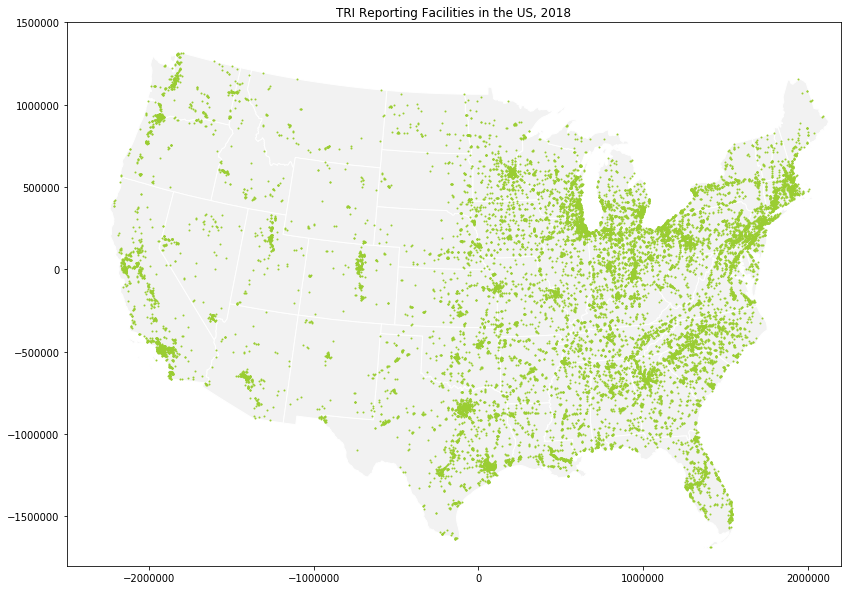

In [15]:
#plot TRI facilities over state basemap to check and visualize distribution
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

#project each layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
gdf_equal = gdf_2018.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
gdf_equal.plot(ax=ax, color='yellowgreen', zorder=1, markersize=1);


ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='TRI Reporting Facilities in the US, 2018');

print;

In [16]:
# export 2018 tri data to geojson
gdf_2018.to_file("../data/map-data/tri-2018.geojson", driver='GeoJSON', encoding='utf-8')

## Wrangle data to get total releases per year <a name="total-releases"></a>

In [17]:
# review dataframe containing all records for every year
tri_filter.head()

,YEAR,TRIFD,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,CHEMICAL,ON_SITE_RELEASE_TOTAL,UNIT_OF_MEASURE
0,1987,94304QLTYT3400H,QUALITY TECH,3400 HILLVIEW AVE,PALO ALTO,SANTA CLARA,CA,94304,37.40348,-122.14600,Computers and Electronic Products,QUALITY TECH,PHOSPHORIC ACID,250.00000,Pounds
1,1987,45377NLNDD480ND,DELPHI ENERGY & CHASSIS VANDALIA OPERATIONS,480 N DIXIE DR,VANDALIA,MONTGOMERY,OH,45377,39.90040,-84.19882,Transportation Equipment,DELPHI AUTOMOTIVE SYSTEMS LLC,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",0.00000,Pounds
2,1987,27215PRKVN1821N,GLEN RAVEN TECHNICAL FABRICS LLC,1821 N PARK AVE,BURLINGTON,ALAMANCE,NC,27217,36.10932,-79.46178,Textiles,GLEN RAVEN TECHNICAL FABRICS LLC,AMMONIUM SULFATE (SOLUTION),0.00000,Pounds
3,1987,70058VNSCP1255P,GREIF USA (DBA GREIF HARVEY DCS HARVEY),1255 PETERS RD,HARVEY,JEFFERSON PARISH,LA,70058,29.88758,-90.07416,Fabricated Metals,GREIF USA,N-NITROSODI-N-PROPYLAMINE,2700.00000,Pounds
4,1987,55425VTCNC2401E,VTC INC RIVER RIDGE,2401 E 28TH ST,BLOOMINGTON,HENNEPIN,MN,55425,44.95979,-93.23143,Computers and Electronic Products,CONTROL DATA CORP,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",0.00000,Pounds


In [18]:
# create pivot table using the year and unique facility identifier as index
# and using an aggregate sum function on the total release field
# to create records per facility per year, with total releases
pivot = pd.pivot_table(tri_filter,index=['YEAR', 'TRIFD'], values=['ON_SITE_RELEASE_TOTAL'],aggfunc=np.sum)
pivot

ON_SITE_RELEASE_TOTAL
YEAR TRIFD                                 
1987 00602BXTRHRD115                0.00000
     00602DSCFPPOBOX            21862.00000
     00602GRNGRAGUAD            14723.00000
     00605BRNQNPR467                0.00000
     00605VNMRBMONTA            19147.00000
...                                     ...
2018 99801CRLSK331CL          2212952.20000
     99801KNNCT13401         55589597.00000
     9980WCRWLY176JA             2185.28000
     99901SCSTG1300S                0.80000
     9990WCRWLY9STED             1397.34000

[747975 rows x 1 columns]

In [19]:
# rename release total column to simplify name
pivot = pivot.rename(columns={'ON_SITE_RELEASE_TOTAL':'TOTAL'})
pivot

TOTAL
YEAR TRIFD                         
1987 00602BXTRHRD115        0.00000
     00602DSCFPPOBOX    21862.00000
     00602GRNGRAGUAD    14723.00000
     00605BRNQNPR467        0.00000
     00605VNMRBMONTA    19147.00000
...                             ...
2018 99801CRLSK331CL  2212952.20000
     99801KNNCT13401 55589597.00000
     9980WCRWLY176JA     2185.28000
     99901SCSTG1300S        0.80000
     9990WCRWLY9STED     1397.34000

[747975 rows x 1 columns]

In [20]:
# unstack pivot table to create one record per facility
# with columns for total release each year
amountsUnstacked = pivot.unstack(level=0)
amountsUnstacked

TOTAL                                                 \
YEAR                   1987        1988        1989        1990       1991   
TRIFD                                                                        
00602BXTRF111CO         nan 11700.00000 12000.00000         nan        nan   
00602BXTRHRD115     0.00000   250.00000     0.00000     0.00000    0.00000   
00602DSCFPPOBOA         nan         nan 17447.00000  4086.00000        nan   
00602DSCFPPOBOX 21862.00000         nan 17717.00000 14730.00000        nan   
00602GRNGRAGUAD 14723.00000         nan 22349.00000 25133.00000 4900.00000   
...                     ...         ...         ...         ...        ...   
99901LSKSH381TN         nan         nan         nan         nan        nan   
99901SCSTG1300S         nan         nan         nan         nan        nan   
99901TSRLS1010S         nan         nan         nan         nan        nan   
9990WCRWLY9STED         nan         nan         nan         nan        nan   
99929TRDNT641SH         nan         nan         nan         nan        nan   

                                                         ...                  \
YEAR               1992    1993    1994    1995    1996  ...    2009    2010   
TRIFD                                                    ...                   
00602BXTRF111CO     nan     nan     nan     nan     nan  ...     nan     nan   
00602BXTRHRD115 0.00000 0.00000 0.00000 0.00000 0.00000  ...     nan     nan   
00602DSCFPPOBOA     nan     nan     nan     nan     nan  ...     nan     nan   
00602DSCFPPOBOX     nan     nan     nan     nan     nan  ...     nan     nan   
00602GRNGRAGUAD     nan     nan     nan     nan     nan  ...     nan     nan   
...                 ...     ...     ...     ...     ...  ...     ...     ...   
99901LSKSH381TN     nan     nan     nan     nan     nan  ...     nan     nan   
99901SCSTG1300S     nan     nan     nan     nan     nan  ... 0.00000 0.00000   
99901TSRLS1010S     nan     nan     nan     nan     nan  ...     nan     nan   
9990WCRWLY9STED     nan     nan     nan     nan     nan  ...     nan     nan   
99929TRDNT641SH     nan     nan     nan     nan     nan  ... 0.00000     nan   

                                                                     \
YEAR                  2011       2012    2013       2014       2015   
TRIFD                                                                 
00602BXTRF111CO        nan        nan     nan        nan        nan   
00602BXTRHRD115        nan        nan     nan        nan        nan   
00602DSCFPPOBOA        nan        nan     nan        nan        nan   
00602DSCFPPOBOX        nan        nan     nan        nan        nan   
00602GRNGRAGUAD        nan        nan     nan        nan        nan   
...                    ...        ...     ...        ...        ...   
99901LSKSH381TN 9362.00000 1534.00000     nan 8043.31460        nan   
99901SCSTG1300S    0.00000    0.00000 0.49320    0.29320    0.10520   
99901TSRLS1010S        nan        nan     nan        nan        nan   
9990WCRWLY9STED        nan        nan     nan 1769.95000 1825.74000   
99929TRDNT641SH        nan        nan     nan        nan        nan   

                                                  
YEAR                  2016       2017       2018  
TRIFD                                             
00602BXTRF111CO        nan        nan        nan  
00602BXTRHRD115        nan        nan        nan  
00602DSCFPPOBOA        nan        nan        nan  
00602DSCFPPOBOX        nan        nan        nan  
00602GRNGRAGUAD        nan        nan        nan  
...                    ...        ...        ...  
99901LSKSH381TN        nan        nan        nan  
99901SCSTG1300S    0.14120    0.11410    0.80000  
99901TSRLS1010S        nan        nan        nan  
9990WCRWLY9STED 1474.49000 1412.03000 1397.34000  
99929TRDNT641SH        nan        nan        nan  

[60528 rows x 32 columns]

In [21]:
# rename columns to reflect year and release type
amountsUnstacked.columns = [''.join(str(s).strip() for s in col if s) for col in amountsUnstacked.columns]
amountsUnstacked

,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,TOTAL1991,TOTAL1992,TOTAL1993,TOTAL1994,TOTAL1995,TOTAL1996,...,TOTAL2009,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018
TRIFD,,,,,,,,,,,,,,,,,,,,,
00602BXTRF111CO,nan,11700.00000,12000.00000,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
00602BXTRHRD115,0.00000,250.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
00602DSCFPPOBOA,nan,nan,17447.00000,4086.00000,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
00602DSCFPPOBOX,21862.00000,nan,17717.00000,14730.00000,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
00602GRNGRAGUAD,14723.00000,nan,22349.00000,25133.00000,4900.00000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99901LSKSH381TN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,9362.00000,1534.00000,nan,8043.31460,nan,nan,nan,nan
99901SCSTG1300S,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.00000,0.00000,0.00000,0.00000,0.49320,0.29320,0.10520,0.14120,0.11410,0.80000
99901TSRLS1010S,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


After bringing this data into Mapbox studio and symbolizing each facility using graduated circles based on the total release amount, I noticed an outlier from 1987 that was producing a circle extending way past the screen bounds. This could be a mistake in the data or not, but I am going to scrub this value for the sake of the map.

In [22]:
# change facility outlier for 1987 to 0
amountsUnstacked.at['93562KRRMC13200', 'TOTAL1987'] = 0

In [23]:
# fill nan values with 0
# create a new row with the total release amount from all facilities per year
amountsUnstacked = amountsUnstacked.fillna(0)
amountsUnstacked.loc['TOTAL_RELEASE']= amountsUnstacked.sum()
amountsUnstacked

,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,TOTAL1991,TOTAL1992,TOTAL1993,TOTAL1994,TOTAL1995,TOTAL1996,...,TOTAL2009,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018
TRIFD,,,,,,,,,,,,,,,,,,,,,
00602BXTRF111CO,0.00000,11700.00000,12000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
00602BXTRHRD115,0.00000,250.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
00602DSCFPPOBOA,0.00000,0.00000,17447.00000,4086.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
00602DSCFPPOBOX,21862.00000,0.00000,17717.00000,14730.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
00602GRNGRAGUAD,14723.00000,0.00000,22349.00000,25133.00000,4900.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99901SCSTG1300S,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.49320,0.29320,0.10520,0.14120,0.11410,0.80000
99901TSRLS1010S,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9990WCRWLY9STED,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1769.95000,1825.74000,1474.49000,1412.03000,1397.34000


### Create csv for total release by all facilities per year <a name="total-release-csv"></a>

I want to display a D3 chart in my map story that shows the total amount released each year by all facilities. I need to create a simple csv for this.

In [24]:
# isolate the last row showing totals per year
yearTotal = amountsUnstacked.tail(1)
yearTotal

,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,TOTAL1991,TOTAL1992,TOTAL1993,TOTAL1994,TOTAL1995,TOTAL1996,...,TOTAL2009,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018
TRIFD,,,,,,,,,,,,,,,,,,,,,
TOTAL_RELEASE,12266349933.00000,5680148075.00000,4452091324.00000,3753465237.00000,3496917822.96000,3318950504.64000,2909276729.72000,2365597221.36000,2387160808.09000,2318409398.65000,...,3038737468.64420,3401823195.53792,3701652530.05003,3232491920.86028,3727353563.30422,3544714287.81079,2972866487.44393,3134064227.29282,3541607790.97415,3367991070.30157


In [25]:
# transpose the table to get one record per year, with a column showing total release
yearTotal = yearTotal.transpose()

yearTotal

TRIFD,TOTAL_RELEASE
TOTAL1987,12266349933.00000
TOTAL1988,5680148075.00000
TOTAL1989,4452091324.00000
TOTAL1990,3753465237.00000
TOTAL1991,3496917822.96000
TOTAL1992,3318950504.64000
TOTAL1993,2909276729.72000
TOTAL1994,2365597221.36000
TOTAL1995,2387160808.09000
TOTAL1996,2318409398.65000


In [26]:
# reset index
yearTotal.reset_index(level=0, inplace=True)

# rename column to YEAR
yearTotal = yearTotal.rename(columns={'index':'YEAR'})

yearTotal

TRIFD,YEAR,TOTAL_RELEASE
0,TOTAL1987,12266349933.00000
1,TOTAL1988,5680148075.00000
2,TOTAL1989,4452091324.00000
3,TOTAL1990,3753465237.00000
4,TOTAL1991,3496917822.96000
5,TOTAL1992,3318950504.64000
6,TOTAL1993,2909276729.72000
7,TOTAL1994,2365597221.36000
8,TOTAL1995,2387160808.09000
9,TOTAL1996,2318409398.65000


In [27]:
# edit year column to remove 'TOTAL' from each year
yearTotal['YEAR'] = yearTotal['YEAR'].str[-4:]
yearTotal

TRIFD,YEAR,TOTAL_RELEASE
0,1987,12266349933.00000
1,1988,5680148075.00000
2,1989,4452091324.00000
3,1990,3753465237.00000
4,1991,3496917822.96000
5,1992,3318950504.64000
6,1993,2909276729.72000
7,1994,2365597221.36000
8,1995,2387160808.09000
9,1996,2318409398.65000


In [28]:
# export to csv
yearTotal.to_csv('../data/map-data/year-totals.csv', index=False)

### Find the top releasing facilities each year <a name="top-facilities"></a>

I cannot keep all records for each year as it is too large for a web map, so I am going to select the top 4000 rows from each year to visualize on the map.

In [29]:
# create empty dataframe
topRows = pd.DataFrame()

# create list of column names
columns = list(amountsUnstacked.columns)

# loop through each column
# finding the 4000 largest values in each
# and appending to empty topRows dataframe
for column in columns:
    topValues = amountsUnstacked.nlargest(4000, column)
    topRows = topRows.append(topValues)

topRows

,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,TOTAL1991,TOTAL1992,TOTAL1993,TOTAL1994,TOTAL1995,TOTAL1996,...,TOTAL2009,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018
TRIFD,,,,,,,,,,,,,,,,,,,,,
TOTAL_RELEASE,12266349933.00000,5680148075.00000,4452091324.00000,3753465237.00000,3496917822.96000,3318950504.64000,2909276729.72000,2365597221.36000,2387160808.09000,2318409398.65000,...,3038737468.64420,3401823195.53792,3701652530.05003,3232491920.86028,3727353563.30422,3544714287.81079,2972866487.44393,3134064227.29282,3541607790.97415,3367991070.30157
77978LMNMCSTATE,468874750.00000,10700650.00000,30250.00000,19605.00000,10855.00000,8513.00000,2086.00000,458.00000,1046.00000,961.00000,...,104538.00000,178771.10000,199796.00000,188280.10000,215479.80000,229453.30000,235630.60000,31152.40000,0.00000,0.00000
76567LMNMCSANDO,329112650.00000,4683150.00000,1448233.00000,1440839.00000,1214510.00000,978813.00000,780927.00000,1177274.00000,914029.00000,1908875.00000,...,180854.27000,264000.00000,353000.00000,159422.00000,133398.00000,62416.00000,0.00000,0.00000,0.00000,0.00000
70094MRCNC10800,217298702.00000,176386400.00000,192340500.00000,162030982.00000,142009076.00000,147088590.00000,120149724.00000,20514100.00000,29534568.00000,28561121.00000,...,14033632.00000,15611971.00000,12514975.00000,13033799.00000,9981778.00000,11626902.87000,12079217.00000,12144943.00000,11604350.00000,14758762.00000
70079SHLLL1205R,194620655.00000,159304466.00000,4960010.00000,3859415.00000,1282081.00000,1432122.00000,1804493.00000,1940255.00000,2422358.00000,2208232.00000,...,909879.54060,962606.12280,877825.43200,1078932.34504,1117847.63374,1088839.50070,890730.06000,1037026.85000,955726.85000,1200867.95450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51459WSTCN461ST,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6264.00000,3244.00000,8130.00000,7600.00000,14120.00000,11640.00000,11640.00000,11540.00000,11660.00000,11660.00000
46516CPLSN435HA,0.00000,2620.00000,3095.00000,2647.00000,2050.00000,3000.00000,3680.00000,3709.00000,2577.00000,2371.00000,...,5335.85000,4952.00000,5965.00000,5482.00000,6860.00000,7422.00000,6756.00000,8243.00000,8123.00000,11655.00000
4816WVNTWR111BR,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,38940.00000,20550.18000,16005.00000,3605.64000,11649.00000


In [30]:
# many facilities made it into the top list for multiple years
# so now I will drop any duplicates
topRows = topRows.drop_duplicates()
topRows

,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,TOTAL1991,TOTAL1992,TOTAL1993,TOTAL1994,TOTAL1995,TOTAL1996,...,TOTAL2009,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018
TRIFD,,,,,,,,,,,,,,,,,,,,,
TOTAL_RELEASE,12266349933.00000,5680148075.00000,4452091324.00000,3753465237.00000,3496917822.96000,3318950504.64000,2909276729.72000,2365597221.36000,2387160808.09000,2318409398.65000,...,3038737468.64420,3401823195.53792,3701652530.05003,3232491920.86028,3727353563.30422,3544714287.81079,2972866487.44393,3134064227.29282,3541607790.97415,3367991070.30157
77978LMNMCSTATE,468874750.00000,10700650.00000,30250.00000,19605.00000,10855.00000,8513.00000,2086.00000,458.00000,1046.00000,961.00000,...,104538.00000,178771.10000,199796.00000,188280.10000,215479.80000,229453.30000,235630.60000,31152.40000,0.00000,0.00000
76567LMNMCSANDO,329112650.00000,4683150.00000,1448233.00000,1440839.00000,1214510.00000,978813.00000,780927.00000,1177274.00000,914029.00000,1908875.00000,...,180854.27000,264000.00000,353000.00000,159422.00000,133398.00000,62416.00000,0.00000,0.00000,0.00000,0.00000
70094MRCNC10800,217298702.00000,176386400.00000,192340500.00000,162030982.00000,142009076.00000,147088590.00000,120149724.00000,20514100.00000,29534568.00000,28561121.00000,...,14033632.00000,15611971.00000,12514975.00000,13033799.00000,9981778.00000,11626902.87000,12079217.00000,12144943.00000,11604350.00000,14758762.00000
70079SHLLL1205R,194620655.00000,159304466.00000,4960010.00000,3859415.00000,1282081.00000,1432122.00000,1804493.00000,1940255.00000,2422358.00000,2208232.00000,...,909879.54060,962606.12280,877825.43200,1078932.34504,1117847.63374,1088839.50070,890730.06000,1037026.85000,955726.85000,1200867.95450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5264WMDWST21WWA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,5783.16000,6742.15000,12112.23000,2845.91000,1301.50000,11852.00000
44301KRNPN1390F,1000.00000,1500.00000,2000.00000,0.00000,3500.00000,21350.00000,9650.00000,5050.00000,12531.00000,15003.00000,...,6820.14000,9237.19000,10546.17000,9793.00000,10995.00000,4513.00000,10058.07000,8358.02000,9168.05000,11740.06000
75090TXSNS6400H,56900.00000,88160.00000,63520.00000,66500.00000,61005.00000,36220.00000,38295.00000,25448.00000,23133.00000,7986.00000,...,5483.00000,7832.00000,8368.00000,7853.00000,8589.00000,12182.00000,10126.00000,11139.00000,10484.00000,11717.00000


In [31]:
# now reduce filtered dataframe to find one record per facility
# use group by TRIFID field, and only keep the identifying fields about each facility
# will use this to join to the release total by year pivot table
all_tri = tri_filter.fillna('').groupby('TRIFD').agg({'FACILITY_NAME':'first',
                             'LATITUDE':'first',
                             'LONGITUDE':'first',
                             'INDUSTRY_SECTOR':'first',
                             'PARENT_CO_NAME': 'first'
                                               }).reset_index()

all_tri

,TRIFD,FACILITY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME
0,00602BXTRF111CO,"BAXTER HEALTHCARE CORP, FENWAL DIV",18.37983,-67.18453,Chemicals,BAXTER SALES CORP
1,00602BXTRHRD115,DADE DIAGNOSTICS OF PR INC,18.38080,-67.19130,Plastics and Rubber,DADE INTERNATIONAL INC
2,00602DSCFPPOBOA,DSC OF PUERTO RICO INC BLDG 9,18.37101,-67.20758,Computers and Electronic Products,DSC COMMUNICATION CORP
3,00602DSCFPPOBOX,DSC OF PUERTO RICO INC BLDG 1,18.37101,-67.20758,Computers and Electronic Products,DSC COMMUNICATION CORP
4,00602GRNGRAGUAD,DSC OF PUERTO RICO INC BLDG 8,18.37101,-67.20758,Computers and Electronic Products,DSC COMMUNICATION CORP
...,...,...,...,...,...,...
60523,99901LSKSH381TN,VIGOR ALASKA,55.35597,-131.69834,Transportation Equipment,VIGOR MARINE
60524,99901SCSTG1300S,US COAST GUARD BASE KETCHIKAN,55.33373,-131.62533,Transportation Equipment,US DEPARTMENT OF HOMELAND SECURITY
60525,99901TSRLS1010S,TESORO ALASKA CO. KETCHIKAN TERMINAL,55.33501,-131.62795,Petroleum Bulk Terminals,TESORO ALASKA CO
60526,9990WCRWLY9STED,CROWLEY KETCHIKAN BULK FUEL STORAGE FACILITY,55.33760,-131.63331,Petroleum Bulk Terminals,CROWLEY FUELS LLC


In [32]:
# merge topRows dataframe to reduced dataframe with one record per facility, with lat/long values
merged = all_tri.merge(topRows, on='TRIFD')
merged

,TRIFD,FACILITY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,...,TOTAL2009,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018
0,00603HWLTTSTATE,HEWLETT-PACKARD CARIBE BV SITE,18.43460,-67.15519,Computers and Electronic Products,HEWLETT-PACKARD CO,0.00000,0.00000,22100.00000,47500.00000,...,19063.53000,4749.17000,6432.61000,5638.60000,6801.90000,1046.20000,0.10000,0.20000,0.00000,0.00000
1,00608DCRBNRD3KM,IDI CARIBE INC,17.97278,-66.23194,Chemicals,,0.00000,0.00000,0.00000,8700.00000,...,12557.38000,12583.38000,13235.38000,14263.38000,16190.38000,15288.38000,15540.38000,14768.38000,13726.38000,13143.38000
2,00610BXTRHROAD4,EDWARDS LIFESCIENCES TECHNOLOGY SARL,18.29390,-67.13660,Miscellaneous Manufacturing,EDWARDS LIFESCIENCES LLC,272140.00000,284986.00000,257625.00000,259455.00000,...,1000.00000,1000.00000,1000.00000,1473.00000,1411.00000,1580.16000,1702.87000,2297.09000,599.00000,580.00000
3,00610LLRGNGPOBO,ALLERGAN MEDICAL OPTICS,18.28629,-67.13591,Machinery,ALLERGAN INC,0.00000,3291.00000,49574.00000,7409.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,00612PRPCMPR681,PREPA-CAMBALACHE COMBUSTION TURBINE PLANT,18.47110,-66.69940,Electric Utilities,PUERTO RICO ELECTRIC POWER AUTHORITY,0.00000,0.00000,0.00000,0.00000,...,114.40000,78.50000,63.50000,24.90000,31.60000,55.90000,82.10000,51.80000,95.60000,42.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13509,99752RDDGP90MIL,RED DOG OPERATIONS,68.06151,-162.85549,Metal Mining,TECK AMERICAN INC,0.00000,0.00000,0.00000,0.00000,...,637521196.30000,777395652.60300,989392511.30300,814003310.83000,906385793.10200,1124384868.58200,561222144.59200,776973928.58100,1082414482.97500,885682874.24200
13510,99801CRLSK331CL,COEUR ALASKA INC KENSINGTON GOLD PROJECT,58.86749,-135.10476,Metal Mining,COEUR MINING INC.,0.00000,0.00000,0.00000,0.00000,...,387.83000,94205.30000,12737.46000,1080831.30000,2010958.46000,1985383.17000,2169999.02000,1951776.90000,2226975.40000,2212952.20000
13511,99801KNNCT13401,HECLA GREENS CREEK MINING CO,58.08180,-134.64121,Metal Mining,HECLA MINING CO,0.00000,0.00000,0.00000,0.00000,...,47242868.62000,47185465.74000,47043841.64000,48754931.74000,50615872.74000,41557030.50000,29951062.50000,41780361.00000,58696349.90000,55589597.00000
13512,99835LSKPLMILE6,ALASKA PULP CORP,57.04764,-135.23290,Paper,,1387500.00000,1524060.00000,1581300.00000,1402950.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Convert to geodataframe and export to geojson <a name="convert-and-export"></a>

In [33]:
# cast lat/long columns to float
merged['LATITUDE'] = merged['LATITUDE'].astype(float)
merged['LONGITUDE'] = merged['LONGITUDE'].astype(float)

# create geodataframe using Latitude and Longitude columns
gdf = gpd.GeoDataFrame(merged, geometry=gpd.points_from_xy(merged.LONGITUDE, merged.LATITUDE))

# define crs for geodataframe
gdf.crs = {'init' :'epsg:4326'}

gdf.head()

,TRIFD,FACILITY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,TOTAL1987,TOTAL1988,TOTAL1989,TOTAL1990,...,TOTAL2010,TOTAL2011,TOTAL2012,TOTAL2013,TOTAL2014,TOTAL2015,TOTAL2016,TOTAL2017,TOTAL2018,geometry
0,00603HWLTTSTATE,HEWLETT-PACKARD CARIBE BV SITE,18.43460,-67.15519,Computers and Electronic Products,HEWLETT-PACKARD CO,0.00000,0.00000,22100.00000,47500.00000,...,4749.17000,6432.61000,5638.60000,6801.90000,1046.20000,0.10000,0.20000,0.00000,0.00000,POINT (-67.15519 18.43460)
1,00608DCRBNRD3KM,IDI CARIBE INC,17.97278,-66.23194,Chemicals,,0.00000,0.00000,0.00000,8700.00000,...,12583.38000,13235.38000,14263.38000,16190.38000,15288.38000,15540.38000,14768.38000,13726.38000,13143.38000,POINT (-66.23194 17.97278)
2,00610BXTRHROAD4,EDWARDS LIFESCIENCES TECHNOLOGY SARL,18.29390,-67.13660,Miscellaneous Manufacturing,EDWARDS LIFESCIENCES LLC,272140.00000,284986.00000,257625.00000,259455.00000,...,1000.00000,1000.00000,1473.00000,1411.00000,1580.16000,1702.87000,2297.09000,599.00000,580.00000,POINT (-67.13660 18.29390)
3,00610LLRGNGPOBO,ALLERGAN MEDICAL OPTICS,18.28629,-67.13591,Machinery,ALLERGAN INC,0.00000,3291.00000,49574.00000,7409.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,POINT (-67.13591 18.28629)
4,00612PRPCMPR681,PREPA-CAMBALACHE COMBUSTION TURBINE PLANT,18.47110,-66.69940,Electric Utilities,PUERTO RICO ELECTRIC POWER AUTHORITY,0.00000,0.00000,0.00000,0.00000,...,78.50000,63.50000,24.90000,31.60000,55.90000,82.10000,51.80000,95.60000,42.20000,POINT (-66.69940 18.47110)


In [34]:
# export geodataframe to geojson
gdf.to_file("../data/map-data/tri-by-year.geojson", driver='GeoJSON', encoding='utf-8')